# Mental Health Sentiment Chatbot Application

## Installing libraries, dependencies, and data

In [1]:

!pip install vaderSentiment
!pip install python-dotenv
!pip install openai
!pip install langchain
!pip install langchain-openai
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 5.6 MB/s eta 0:00:00


In [2]:
pip show numpy pandas

Name: numpy
Version: 2.0.2
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2024, NumPy Developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are
met:

    * Redistributions of source code must retain the above copyright
       notice, this list of conditions and the following disclaimer.

    * Redistributions in binary form must reproduce the above
       copyright notice, this list of conditions and the following
       disclaimer in the documentation and/or other materials provided
       with the distribution.

    * Neither the name of the NumPy Developers nor the names of any
       contributors may be used to endorse or promote products derived
       from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRI

In [3]:
# Import the required libraries and dependencies
import pandas as pd
from matplotlib import pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from dotenv import load_dotenv
import os
from langchain_openai import ChatOpenAI
from langchain import PromptTemplate
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

import gradio as gr
import joblib
# Set the column width to view the statments.
pd.set_option('max_colwidth', 200)

In [4]:
# Load the dataset.
df = pd.read_csv("https://drive.google.com/uc?id=1Ckgzg1fnihYANNPBTH26eCinRmukBGpo", index_col="Unnamed: 0")
# Display a sample of the dataset.
df.sample(5)

,statement,status
49797,My Tattoos are done healing (mostly I think) I got these 2 a while back. The semicolon healed poorly and I had to go back for a touch up. The other one also needed some minor adjustments. But now ...,Bipolar
12651,I am grateful for the cool weather I am grateful for the desire to go for a walk this morning I am grateful for waterI am grateful for the desire to make life better I am grateful for tumsI'm runn...,Depression
6851,He's sleepy,Normal
50592,Zero sex drive while hypomanic It's the only symptom I don't experience with hypomania. It's actually the opposite—I am so high strung and hyperfixated on so many things that I completely forget a...,Bipolar
31958,what for?,Normal


## Data Cleanup and Preparation

In [5]:
# Check for missing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [6]:
# Null values in the statement column
df['statement'].notnull().value_counts()

,count
statement,
True,52681
False,362


In [7]:
# Drop null values
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     52681 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [8]:
# Get the number of different statuses in the status column:
status_count = df['status'].value_counts()
status_count

,count
status,
Normal,16343
Depression,15404
Suicidal,10652
Anxiety,3841
Bipolar,2777
Stress,2587
Personality disorder,1077


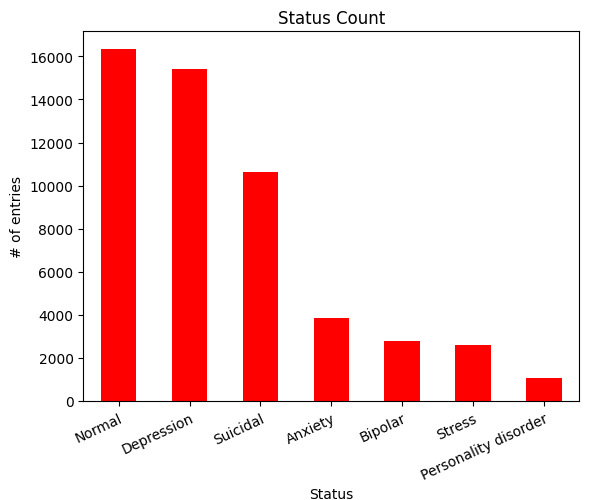

In [9]:
status_chart = status_count.plot(
    kind='bar',
    facecolor='r',
    title='Status Count',
    xlabel='Status',
    ylabel='# of entries'
)
ticks = status_count.index
status_chart.set_xticklabels(ticks, rotation=25, rotation_mode='anchor', ha='right', wrap=True)
plt.show()

In [10]:
# Turning the statement column to a list.
statements = df['statement'].to_list()
statements

['oh my gosh',
 'trouble sleeping, confused mind, restless heart. All out of tune',
 'All wrong, back off dear, forward doubt. Stay in a restless and restless place',
 "I've shifted my focus to something else but I'm still worried",
 "I'm restless and restless, it's been a month now, boy. What do you mean?",
 'every break, you must be nervous, like something is wrong, but what the heck',
 'I feel scared, anxious, what can I do? And may my family or us be protected :)',
 "Have you ever felt nervous but didn't know why?",
 "I haven't slept well for 2 days, it's like I'm restless. why huh :([].",
 "I'm really worried, I want to cry.",
 "always restless every night, even though I don't know why, what's wrong. strange.",
 "I'm confused, I'm not feeling good lately. Every time I want to sleep, I always feel restless",
 'sometimes what is needed when there is a problem is to laugh until you forget that there is a problem, when you remember it, you feel restless like that well, it turns out th

In [13]:
# Using the analyzer to determine the sentiment of each statement.
sentiment = []
score = []
analyzer = SentimentIntensityAnalyzer()
for statement in statements:
    statement_sentiment = analyzer.polarity_scores(statement)
    if statement_sentiment['compound'] >= 0.05:
        sentiment.append("Positive")

    elif statement_sentiment['compound'] <= - 0.05:
        sentiment.append("Negative")

    else:
        sentiment.append("Neutral")
    score.append(statement_sentiment['compound'])

In [14]:
# Creating sentiment and score columns.
df['sentiment'] = sentiment
df['score'] = score
df.head()

,statement,status,sentiment,score
0,oh my gosh,Anxiety,Neutral,0.0000
1,"trouble sleeping, confused mind, restless heart. All out of tune",Anxiety,Negative,-0.2263
2,"All wrong, back off dear, forward doubt. Stay in a restless and restless place",Anxiety,Negative,-0.7351
3,I've shifted my focus to something else but I'm still worried,Anxiety,Negative,-0.4215
4,"I'm restless and restless, it's been a month now, boy. What do you mean?",Anxiety,Negative,-0.4939


In [15]:
# Displaying a sample of the new DataFrame.
df.sample(10)

,statement,status,sentiment,score
48726,Introduction to a set of release techniques which proved to be a great asset in fighting with stress [youtube.com/watch?v=HNA5OV1-hW0](https://youtube.com/watch?v=HNA5OV1-hW0),Stress,Positive,0.3939
6389,hi guys how are you i'm back,Normal,Neutral,0.0000
11884,"Hi,I am in a rough place right now with no one to turn to, so here is hoping typing it out will make a difference.A bit of background: I am nearly 30, and I suffer from anxiety and depression. My ...",Depression,Negative,-0.9972
1419,"hey, those who like jbjb, let's be moots.. all fandom hehe. help like/rt, thank you â",Normal,Positive,0.7717
41001,this ha to change drastically and quickly so i can still breathe fuck depression fuck fear i stand by you the community it s time to dance http t co 0yongk cf,Depression,Negative,-0.9100
41119,i m pretty sure the gym is curing my depression bc i ve been a funny mf lately,Depression,Positive,0.5719
49456,I found the solution to your stress at last! https://youtu.be/xbT9fyTc4Io,Stress,Negative,-0.2003
38044,amp x 00b how do u deal with the loneliness when living alone how do u engage yourself who do u talk to i literally crave some human being to talk to but have only few friend,Depression,Positive,0.5574
52941,"Health anxiety i've noticed that over the last year i've become super anxious when it comes mine and my loved ones health, i think it's because my husband had bells palsy early last year. \n\nSinc...",Anxiety,Positive,0.2730
43254,goodnight everyone well i m not feeling much better and i m going to the doctor tomorrow,Normal,Negative,-0.1719


In [16]:
# Get the number of different results in the sentiment column:
sentiment_count = df['sentiment'].value_counts()
sentiment_count

,count
sentiment,
Negative,28780
Positive,17394
Neutral,6507


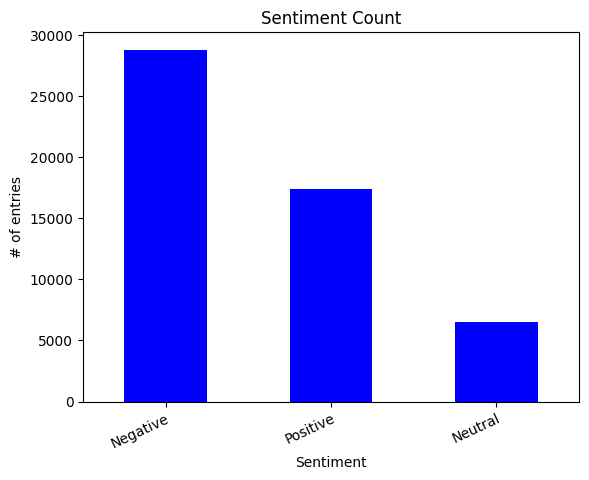

In [17]:
sentiment_chart = sentiment_count.plot(
    kind='bar',
    facecolor='b',
    title='Sentiment Count',
    xlabel='Sentiment',
    ylabel='# of entries'
)
ticks = sentiment_count.index
sentiment_chart.set_xticklabels(ticks, rotation=25, rotation_mode='anchor', ha='right', wrap=True)
plt.show()

In [18]:
# Set the features variable.
X = df['statement']
# Set the target variables.
y_status = df['status']
y_sentiment = df['sentiment']

In [19]:
# Split data into training and testing for status
X_status_train, X_status_test, y_status_train, y_status_test = train_test_split(X, y_status, test_size=0.25, random_state=1)

In [20]:
# Split data into training and testing for sentiment
X_sentiment_train, X_sentiment_test, y_sentiment_train, y_sentiment_test = train_test_split(X, y_sentiment, test_size=0.30, random_state=1)

## ML Model

Title: y_status_train

In [21]:
if os.path.exists("status_model.pkl") and os.path.exists("sentiment_model.pkl"):
    status_pipeline = joblib.load("status_model.pkl")
    sentiment_pipeline = joblib.load("sentiment_model.pkl")
else:
    status_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words="english")),
        ('classifier', LinearSVC())
    ])
    sentiment_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words="english")),
        ('classifier', LinearSVC())
    ])
    status_pipeline.fit(X_status_train, y_status_train)
    sentiment_pipeline.fit(X_sentiment_train, y_sentiment_train)
    joblib.dump(status_pipeline, "status_model.pkl")  # 🔴 Save model
    joblib.dump(sentiment_pipeline, "sentiment_model.pkl")  # 🔴 Save model

In [22]:
import os
print("Current working directory:", os.getcwd())
print("Files in current directory:", os.listdir())


Current working directory: /content
Files in current directory: ['.config', 'status_model.pkl', 'sentiment_model.pkl', 'sample_data']


In [23]:
from google.colab import files
files.download('status_model.pkl')
files.download('sentiment_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
# Show the test data and corresponding predictions
# Predict on the test set
status_predictions = status_pipeline.predict(X_status_test)
sentiment_predictions = sentiment_pipeline.predict(X_sentiment_test)

status_test_results = pd.DataFrame({'X_test': X_status_test, 'Predicted_y': status_predictions, 'Actual_y': y_status_test})
print(status_test_results)

                                                                                                                                                                                                        X_test  \
39488  i m and i have bad anxiety debilitating i haven t been able to keep a job since i wa so pretty much ever i wake up early morning hour before i have to be my heart race i black out i puke cough my ...   
1480                                                                                                               Jessica starred in the musical "Legally Blonde" as Elle Woods, the female lead in the drama   
47948  I’m so tired I just don’t see a point to my suffering, I don’t understand it, I want to know what I’ve done so wrong to deserve everything, I’d say sorry and do anything to make it stop! I already...   
19681  My life 1 year ago was completely different. I was such a chick magnet and everyone loved me i had so many friends and in this past year i lost everythin

In [25]:
# Validate the model by checking the model's training and testing accuracy.
training_accuracy = status_pipeline.score(X_status_train, y_status_train)
testing_accuracy = status_pipeline.score(X_status_test, y_status_test)
print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

Training Accuracy: 0.9371551505947862
Testing Accuracy: 0.7584845493888087


In [27]:
# Create the confusion matrix
confusion_mat = confusion_matrix(y_status_test, status_predictions)

# Print the confusion matrix
print("Status Confusion Matrix:")
print(confusion_mat)

# Print a classification report
print("Status Classification Report:")
print(classification_report(y_status_test, status_predictions))

# Print the overall accuracy
accuracy = accuracy_score(y_status_test, status_predictions)
print("Overall Accuracy:", accuracy)

Status Confusion Matrix:
[[ 726    7  109   65    6   24    6]
 [  18  505   74   35    5   14   20]
 [  65   44 2728  197    8   33  804]
 [  28    7  122 3856    3   41   80]
 [   4    3   74   24  147    7   11]
 [  52   14  131   97    5  297   25]
 [  14   11  699  177    2   16 1731]]
Status Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.80      0.77      0.78       943
             Bipolar       0.85      0.75      0.80       671
          Depression       0.69      0.70      0.70      3879
              Normal       0.87      0.93      0.90      4137
Personality disorder       0.84      0.54      0.66       270
              Stress       0.69      0.48      0.56       621
            Suicidal       0.65      0.65      0.65      2650

            accuracy                           0.76     13171
           macro avg       0.77      0.69      0.72     13171
        weighted avg       0.76      0.76      0.76     

Title: y_sentiment_train

In [28]:
sentiment_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=None)),
    ('classifier', LinearSVC())
])

sentiment_pipeline.fit(X_sentiment_train, y_sentiment_train)

# Print the results
sentiment_predictions = sentiment_pipeline.predict(X_sentiment_test)
print(sentiment_predictions)


['Positive' 'Positive' 'Negative' ... 'Negative' 'Neutral' 'Negative']


In [29]:
# Show the test data and corresponding predictions
sentiment_test_results = pd.DataFrame({'X_test': X_sentiment_test, 'Predicted_y': sentiment_predictions, 'Actual_y': y_sentiment_test})
print(sentiment_test_results)

                                                                                                                                                                                                        X_test  \
39488  i m and i have bad anxiety debilitating i haven t been able to keep a job since i wa so pretty much ever i wake up early morning hour before i have to be my heart race i black out i puke cough my ...   
1480                                                                                                               Jessica starred in the musical "Legally Blonde" as Elle Woods, the female lead in the drama   
47948  I’m so tired I just don’t see a point to my suffering, I don’t understand it, I want to know what I’ve done so wrong to deserve everything, I’d say sorry and do anything to make it stop! I already...   
19681  My life 1 year ago was completely different. I was such a chick magnet and everyone loved me i had so many friends and in this past year i lost everythin

In [30]:
# Validate the model by checking the model's training and testing accuracy.
training_accuracy = sentiment_pipeline.score(X_sentiment_train, y_sentiment_train)
testing_accuracy = sentiment_pipeline.score(X_sentiment_test, y_sentiment_test)
print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

Training Accuracy: 0.946415012474238
Testing Accuracy: 0.8268269534957292


In [31]:
# Create the confusion matrix
confusion_mat = confusion_matrix(y_sentiment_test, sentiment_predictions)

# Print the confusion matrix
print("Sentiment Confusion Matrix:")
print(confusion_mat)

# Print a classification report
print("Sentiment Classification Report:")
print(classification_report(y_sentiment_test, sentiment_predictions))

# Print the overall accuracy
accuracy = accuracy_score(y_sentiment_test, sentiment_predictions)
print("Overall Accuracy:", accuracy)

Sentiment Confusion Matrix:
[[7683  206  813]
 [ 253 1389  269]
 [ 999  197 3996]]
Sentiment Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.88      0.87      8702
     Neutral       0.78      0.73      0.75      1911
    Positive       0.79      0.77      0.78      5192

    accuracy                           0.83     15805
   macro avg       0.81      0.79      0.80     15805
weighted avg       0.83      0.83      0.83     15805

Overall Accuracy: 0.8268269534957292


Stopwords

In [32]:
status_pipeline_stopwords = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words="english")),
    ('classifier', LinearSVC())
])

status_pipeline_stopwords.fit(X_status_train, y_status_train)

# Print the results
status_predictions_stopwords = status_pipeline_stopwords.predict(X_status_test)
print(status_predictions_stopwords)

['Depression' 'Normal' 'Bipolar' ... 'Normal' 'Depression' 'Normal']


In [33]:
# Show the test data and corresponding predictions
status_stopwords_test_results = pd.DataFrame({'X_test': X_status_test, 'Predicted_y': status_predictions_stopwords, 'Actual_y': y_status_test})
print(status_stopwords_test_results)

                                                                                                                                                                                                        X_test  \
39488  i m and i have bad anxiety debilitating i haven t been able to keep a job since i wa so pretty much ever i wake up early morning hour before i have to be my heart race i black out i puke cough my ...   
1480                                                                                                               Jessica starred in the musical "Legally Blonde" as Elle Woods, the female lead in the drama   
47948  I’m so tired I just don’t see a point to my suffering, I don’t understand it, I want to know what I’ve done so wrong to deserve everything, I’d say sorry and do anything to make it stop! I already...   
19681  My life 1 year ago was completely different. I was such a chick magnet and everyone loved me i had so many friends and in this past year i lost everythin

In [34]:
# Validate the model by checking the model's training and testing accuracy.
training_accuracy = status_pipeline_stopwords.score(X_status_train, y_status_train)
testing_accuracy = status_pipeline_stopwords.score(X_status_test, y_status_test)
print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

Training Accuracy: 0.9371551505947862
Testing Accuracy: 0.7584845493888087


In [35]:
# Create the confusion matrix
confusion_mat = confusion_matrix(y_status_test, status_predictions_stopwords)

# Print the confusion matrix
print("Status Confusion Matrix:")
print(confusion_mat)

# Print a classification report
print("Status Classification Report:")
print(classification_report(y_status_test, status_predictions_stopwords))

# Print the overall accuracy
accuracy = accuracy_score(y_status_test, status_predictions_stopwords)
print("Overall Accuracy:", accuracy)

Status Confusion Matrix:
[[ 726    7  109   65    6   24    6]
 [  18  505   74   35    5   14   20]
 [  65   44 2728  197    8   33  804]
 [  28    7  122 3856    3   41   80]
 [   4    3   74   24  147    7   11]
 [  52   14  131   97    5  297   25]
 [  14   11  699  177    2   16 1731]]
Status Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.80      0.77      0.78       943
             Bipolar       0.85      0.75      0.80       671
          Depression       0.69      0.70      0.70      3879
              Normal       0.87      0.93      0.90      4137
Personality disorder       0.84      0.54      0.66       270
              Stress       0.69      0.48      0.56       621
            Suicidal       0.65      0.65      0.65      2650

            accuracy                           0.76     13171
           macro avg       0.77      0.69      0.72     13171
        weighted avg       0.76      0.76      0.76     

In [36]:
sentiment_pipeline_stopwords = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words="english")),
    ('classifier', LinearSVC())
])

sentiment_pipeline_stopwords.fit(X_sentiment_train, y_sentiment_train)

# Print the results
sentiment_predictions_stopwords = sentiment_pipeline_stopwords.predict(X_sentiment_test)
print(sentiment_predictions_stopwords)

['Positive' 'Positive' 'Negative' ... 'Negative' 'Neutral' 'Negative']


In [37]:
# Show the test data and corresponding predictions
sentiment_stopwords_test_results = pd.DataFrame({'X_test': X_sentiment_test, 'Predicted_y': sentiment_predictions_stopwords, 'Actual_y': y_sentiment_test})
print(sentiment_stopwords_test_results)

                                                                                                                                                                                                        X_test  \
39488  i m and i have bad anxiety debilitating i haven t been able to keep a job since i wa so pretty much ever i wake up early morning hour before i have to be my heart race i black out i puke cough my ...   
1480                                                                                                               Jessica starred in the musical "Legally Blonde" as Elle Woods, the female lead in the drama   
47948  I’m so tired I just don’t see a point to my suffering, I don’t understand it, I want to know what I’ve done so wrong to deserve everything, I’d say sorry and do anything to make it stop! I already...   
19681  My life 1 year ago was completely different. I was such a chick magnet and everyone loved me i had so many friends and in this past year i lost everythin

In [38]:
# Validate the model by checking the model's training and testing accuracy.
training_accuracy = sentiment_pipeline_stopwords.score(X_sentiment_train, y_sentiment_train)
testing_accuracy = sentiment_pipeline_stopwords.score(X_sentiment_test, y_sentiment_test)
print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

Training Accuracy: 0.9489369779802581
Testing Accuracy: 0.808731414109459


In [39]:
# Create the confusion matrix
confusion_mat = confusion_matrix(y_sentiment_test, sentiment_predictions_stopwords)

# Print the confusion matrix
print("Sentiment Confusion Matrix:")
print(confusion_mat)

# Print a classification report
print("Sentiment Classification Report:")
print(classification_report(y_sentiment_test, sentiment_predictions_stopwords))

# Print the overall accuracy
accuracy = accuracy_score(y_sentiment_test, sentiment_predictions_stopwords)
print("Overall Accuracy:", accuracy)

Sentiment Confusion Matrix:
[[7544  238  920]
 [ 271 1350  290]
 [1048  256 3888]]
Sentiment Classification Report:
              precision    recall  f1-score   support

    Negative       0.85      0.87      0.86      8702
     Neutral       0.73      0.71      0.72      1911
    Positive       0.76      0.75      0.76      5192

    accuracy                           0.81     15805
   macro avg       0.78      0.77      0.78     15805
weighted avg       0.81      0.81      0.81     15805

Overall Accuracy: 0.808731414109459


In [41]:
# 📦 Install required package
!pip install groq python-dotenv

# 🔐 Secure API Key Handling
import os
from dotenv import load_dotenv
from groq import Groq

# 🔄 Load environment variables from .env file (or from Hugging Face Secrets)
load_dotenv()

# ✅ Get API Key
groq_api_key = os.getenv("GROQ_API_KEY")
if not groq_api_key:
    raise ValueError("❌ GROQ_API_KEY not found. Set it in .env or Hugging Face Secrets.")

# 🔗 Set up Groq client
groq_client = Groq(api_key=groq_api_key)

# 💬 Store conversation history
chat_history = []


In [4]:
def mental_health_chatbot(message, history):
    try:
        global chat_history

        if message.lower() == "reset":
            chat_history.clear()
            return "🔄 Chat has been reset. How can I support you today?"

        # Predict
        status = status_pipeline.predict([message])[0]
        sentiment = sentiment_pipeline.predict([message])[0]

        chat_history.append({"role": "user", "content": message})

        if not any(msg["role"] == "system" for msg in chat_history):
            chat_history.insert(0, {
                "role": "system",
                "content": (
                    "You are a professional mental health chatbot trained to respond like a licensed clinical psychologist.\n\n"
                    "- Only respond to queries related to mental health.\n"
                    "- Maintain a calm, professional, and empathetic tone.\n"
                    "- Avoid casual suggestions unless clinically appropriate.\n"
                    "- Encourage seeking help from professionals.\n"
                    "- If unsure, say 'I'm not able to provide a reliable answer to that.'"
                )
            })

        # Groq response
        response = groq_client.chat.completions.create(
            model="llama3-70b-8192",  # Updated model ID
            messages=chat_history,
            temperature=0.7,
            max_tokens=300
        )

        reply = response.choices[0].message.content.strip()
        chat_history.append({"role": "assistant", "content": reply})

        return f"""
🧠 **Detected Sentiment:** {sentiment.capitalize()}
📋 **Detected Mental Health Status:** {status.capitalize()}

💬 **Bot Response:**
{reply}
        """

    except Exception as e:
        return f"❌ Error: {str(e)}"


## Gradio App

In [43]:
!pip install --upgrade gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 24.1 MB/s eta 0:00:00
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 1.10.1
    Uninstalling gradio_client-1.10.1:
      Successfully uninstalled gradio_client-1.10.1
  Attempting uninstall: gradio
    Found existing installation: gradio 5.31.0
    Uninstalling gradio-5.31.0:
      Successfully uninstalled gradio-5.31.0


In [44]:
# import gradio as gr

# gr.ChatInterface(
#     fn=mental_health_chatbot
# ).launch()


In [5]:
import gradio as gr

# Launch the improved UI
gr.ChatInterface(
    fn=mental_health_chatbot,
    title="🧠 Mental Health Companion",
    description="Welcome! I'm always here to listen. Feel free to share your thoughts. 💬",
    theme="soft",
    examples=["I'm feeling anxious.", "I can't sleep at night.", "I had a rough day today."],
    type="messages",
    css="""
    .gr-input, .gr-output, .gr-button {
        margin: 15px;
    }
    """
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3acd00e7f2b9e50268.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [46]:
!pip freeze > requirements.txt

In [47]:
!cat requirements.txt


absl-py==1.4.0
accelerate==1.7.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.1
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.1.0
astropy-iers-data==0.2025.5.26.0.37.21
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.4.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.0.0
blosc2==3.3.4
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.4.26
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.2
chex==0.1.89
clarabel==0.11.0
click==8.2.1
cloudpathlib==0.21.1
cloudpickle==3.1.1
cmake==3.31.6
cmdstanp

In [48]:
from google.colab import files
files.download('requirements.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>